In [12]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import urllib, json

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Introduction to Networkx

The simple methods '.nodes()' and '.edges()' print the key components of the network.

In [2]:
HG = nx.house_graph()
HG.nodes()
HG.edges()

NodeView((0, 1, 2, 3, 4))

EdgeView([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])

## Drawing the network

To draw the network, we need to give it a dictionary that maps each node to an X-Y coordinate. I give one below.

{0: Text(0, 0, '0'),
 1: Text(1, 0, '1'),
 2: Text(0, 1, '2'),
 3: Text(1, 1, '3'),
 4: Text(0.5, 2.0, '4')}

(-0.10500000000000001, 1.105, -0.21000000000000002, 2.21)

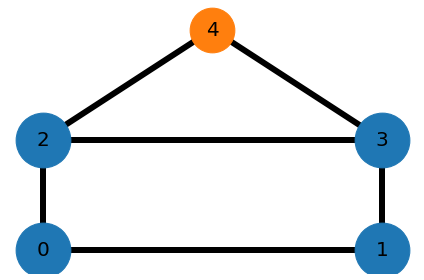

In [3]:
pos = {0: (0, 0), 1: (1, 0), 2: (0, 1), 3: (1, 1), 4: (0.5, 2.0)}

nx.draw_networkx_nodes(
    HG, pos, node_size=3000, nodelist=[0, 1, 2, 3], 
    node_color="tab:blue"
)

nx.draw_networkx_nodes(HG, pos, node_size=2000, 
                       nodelist=[4], node_color="tab:orange")

nx.draw_networkx_edges(HG, pos, alpha=1, width=6)
nx.draw_networkx_labels(HG, pos, font_size=20)
plt.tight_layout()
plt.axis("off")

In [4]:
ADJ = nx.to_pandas_adjacency(HG)
ADJ = ADJ.astype(bool)

In [5]:
deg_0 = nx.degree(HG, 0) 
deg_0

2

# Activity
We will learn how to process a dataframe into a useable edgelist to feed into a graph.

In [7]:
df = pd.read_pickle("../../public_data/Raw_Tweets.pkl") # Load your tweets
df.head()
df.shape

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN
28315,1221213073652043776,14499829,Sat Jan 25 23:27:40 +0000 2020,en,WHO’s risk assessment of the new #coronavirus ...,original,1743,5196950,46697,[],NaN,NaN,NaN,NaN,NaN
6092,1222281847163576321,1135486501,Tue Jan 28 22:14:35 +0000 2020,en,#FYI: 50 million are under travel restrictions...,original,950,27025,11145,[9624742],NaN,NaN,NaN,NaN,NaN
13618,1222289121118511104,117793973,Tue Jan 28 22:43:30 +0000 2020,en,What should I do if I have traveled to China a...,original,1236,5860,4578,[],NaN,NaN,NaN,NaN,NaN
19205,1222285279047843843,1465196934,Tue Jan 28 22:28:14 +0000 2020,en,Disease outbreaks can result in misinformation...,original,1946,3581,4636,[],NaN,NaN,NaN,NaN,NaN


(59887, 15)

### 1.1 Subset the dataframe to network data

- First, using .value_counts(), identify how many types of tweets there are, using the tweet_type column. 
- Then, filter out all tweets that are not "retweeted_tweet_without_comment" and "quoted_tweet."

In [8]:
# your code here
df.tweet_type.value_counts()

tweet_type
original                           26275
retweeted_tweet_without_comment    19923
reply                               7292
quoted_tweet                        6397
Name: count, dtype: int64

In [9]:
df = df[(df.tweet_type == "retweeted_tweet_without_comment") | (df.tweet_type == "quoted_tweet")]

In [10]:
## Run this. Why is it empty?
df[(df.tweet_type == "retweeted_tweet_without_comment") & (df.tweet_type == "quoted_tweet")]

,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid


### 1.2 Create an edgelist

The "userid" column shows the person that did the retweeting. Create a new column called "userid2" that denotes the user retweeted. You will need to use the columns "rt_userid" and "qtd_userid."

In [13]:
%%time
user2 = []
for i,r in df.iterrows():
    if np.isnan( r.rt_userid ):
        user2.append(r.qtd_userid)
    else:
        user2.append(r.rt_userid)
df["user2"] = user2

CPU times: user 887 ms, sys: 11.9 ms, total: 899 ms
Wall time: 899 ms


In [14]:
%%time
df["user2"] = np.where(df.rt_userid.isnull(), df.qtd_userid, df.rt_userid)
df

CPU times: user 3.72 ms, sys: 1.02 ms, total: 4.74 ms
Wall time: 4.04 ms


,tweetid,userid,date,lang,text,tweet_type,friends_count,followers_count,statuses_count,mentionid,rt_userid,rt_tweetid,qtd_userid,qtd_text,qtd_tweetid,user2
12221,1221208309728006145,418859255,Sat Jan 25 23:08:44 +0000 2020,en,"RT @DepSecHargan: Every year in the US, 34,800...",retweeted_tweet_without_comment,638,1837,17778,[920035992073064450],9.200360e+17,1.221208e+18,NaN,NaN,NaN,9.200360e+17
25575,1222280171501256706,20467163,Tue Jan 28 22:07:56 +0000 2020,en,RT @RCCallihan: The declaration of a public he...,retweeted_tweet_without_comment,10261,30106,2762,"[1697808410, 146569971]",1.697808e+09,1.222247e+18,NaN,NaN,NaN,1.697808e+09
28489,1222283902724820995,426033838,Tue Jan 28 22:22:46 +0000 2020,en,RT @DepSecHargan: Start the #NewYear off right...,retweeted_tweet_without_comment,625,1823,22314,"[920035992073064450, 146569971]",9.200360e+17,1.222239e+18,NaN,NaN,NaN,9.200360e+17
28496,1222283757119590405,426033838,Tue Jan 28 22:22:11 +0000 2020,en,RT @CDCFlu: Elevated #flu activity is expected...,retweeted_tweet_without_comment,625,1823,22314,[16616061],1.661606e+07,1.222194e+18,NaN,NaN,NaN,1.661606e+07
12992,1220696703667326976,426033838,Fri Jan 24 13:15:48 +0000 2020,en,RT @CDCemergency: Is it a cold or flu? What’s ...,retweeted_tweet_without_comment,625,1822,22325,[19658936],1.965894e+07,1.220488e+18,NaN,NaN,NaN,1.965894e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178123,1311697178453254145,13218102,Thu Oct 01 15:59:12 +0000 2020,en,RT @TexasDSHS: Today is #TexasFluDay! A yearly...,retweeted_tweet_without_comment,12181,290055,40056,[68412042],6.841204e+07,1.311671e+18,NaN,NaN,NaN,6.841204e+07
71249,1320008044714098688,2987671552,Sat Oct 24 14:23:37 +0000 2020,en,"RT @MDHealthDept: Today, @MDHealthDept reports...",retweeted_tweet_without_comment,998,206890,9632,"[44961877, 44961877]",4.496188e+07,1.320005e+18,NaN,NaN,NaN,4.496188e+07
111383,1320011408311001090,2891165960,Sat Oct 24 14:36:59 +0000 2020,en,"RT @unmc: .@HHSGov Deputy Secretary, Eric D. H...",retweeted_tweet_without_comment,1212,32893,8014,"[16151917, 44783853]",1.615192e+07,1.320011e+18,NaN,NaN,NaN,1.615192e+07
159487,1320015440249225218,44783853,Sat Oct 24 14:53:00 +0000 2020,en,RT @CDCgov: Today is a good day to talk with y...,retweeted_tweet_without_comment,396,1013652,22511,[146569971],1.465700e+08,1.318949e+18,NaN,NaN,NaN,1.465700e+08


In [15]:
%%time
df.rt_userid.combine_first(df.qtd_userid)

CPU times: user 4.74 ms, sys: 1.71 ms, total: 6.45 ms
Wall time: 5.81 ms


12221     9.200360e+17
25575     1.697808e+09
28489     9.200360e+17
28496     1.661606e+07
12992     1.965894e+07
              ...     
178123    6.841204e+07
71249     4.496188e+07
111383    1.615192e+07
159487    1.465700e+08
166622    3.762414e+09
Name: rt_userid, Length: 26320, dtype: float64

In [16]:
%%time
df.rt_userid.fillna(0) + df.qtd_userid.fillna(0)

CPU times: user 4.19 ms, sys: 817 µs, total: 5 ms
Wall time: 4.66 ms


12221     9.200360e+17
25575     1.697808e+09
28489     9.200360e+17
28496     1.661606e+07
12992     1.965894e+07
              ...     
178123    6.841204e+07
71249     4.496188e+07
111383    1.615192e+07
159487    1.465700e+08
166622    3.762414e+09
Length: 26320, dtype: float64

### 1.3 Sentiment scoring. 
- Now, use SentimentIntensityAnalyzer to label the sentiment of the text, in a new column called "weight." 
- The subset the dataframe to only have "userid", "user2", and "weight". 
- Rename "userid" to "user1", then group by "user1" and "user2", to find the mean sentiment (mean weight).

You now have your first edgelist!

In [17]:
%%time
S = SentimentIntensityAnalyzer()
df["vaderSent"] = df.text.apply(lambda x: S.polarity_scores(x)["compound"])

CPU times: user 4.84 s, sys: 12.7 ms, total: 4.85 s
Wall time: 4.85 s


In [18]:
df = df[["userid", "user2", "vaderSent"]]
df.columns = ["user1", "user2", "weights"]

In [19]:
df.groupby(["user1", "user2"])["weights"].mean().reset_index()

,user1,user2,weights
0,5558312,5.558312e+06,0.7263
1,5558312,2.009386e+07,0.6705
2,5558312,2.056292e+07,0.5106
3,5558312,2.874303e+07,0.5106
4,5558312,5.090780e+07,0.8831
...,...,...,...
9365,815952318487298048,1.008376e+18,0.4404
9366,815952318487298048,1.080866e+18,-0.4019
9367,1075205691621720064,3.382592e+09,0.0000
9368,1075205691621720064,1.075206e+18,0.7717


# Netwulf Visualization
#### If you don't have the module, pip install netwulf
#### https://netwulf.readthedocs.io/en/latest/about.html

In [21]:
EL =  pd.read_pickle("../../public_data/edge_list_final2.pkl")

In [22]:
EL[["user1","user2"]].values

array([[ 426033838,  146569971],
       [ 418859255,  146569971],
       [ 418859255,  146569971],
       ...,
       [2953974395,    5558312],
       [2953974395, 1209417007],
       [  18023868,   23711785]])

In [23]:
G = nx.Graph() # Creates a graph object
G.add_edges_from( EL[["user1","user2"]].values ) # Adds edges (and hence nodes from the edgelist)

# Creates the biggest subgraph
CC_nodes = list( nx.connected_components(G) )[0] # Generates a list of connected components, extracts the largest
GG = nx.subgraph(G, CC_nodes) # Creates the subgraph of the largest CC

In [24]:
from netwulf import visualize
import netwulf as nw

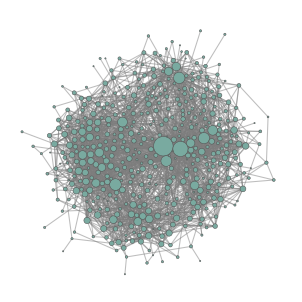

In [53]:
stylized_network, config = visualize(GG,)

In [54]:
U = pd.read_pickle("../public_data/UserInfo.pkl")
id2color = dict(zip(U.userid.values, U.PlotColor.values))
for k, v in GG.nodes(data=True):
    v["group"] = id2color[k]

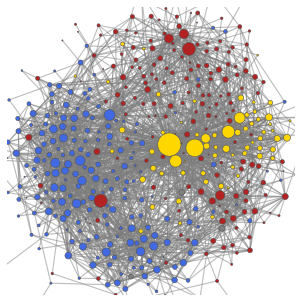

In [55]:
stylized_network, config = visualize(GG,port=2000)

### Activity Two
- Create a new column in U called "Degree," which denotes the degree of the node (userid). You will want to use G.degree()[n] where n is the userid.
- Group by User Type. Which group was the most popular during the pandemic?

In [68]:
%%time
DEG = pd.DataFrame(G.degree(), columns = ["userid", "degree"])
U = U.merge(DEG) 

CPU times: user 8.09 ms, sys: 10.5 ms, total: 18.6 ms
Wall time: 21.2 ms


In [70]:
U.groupby("User_type")["degree"].mean()

User_type
Democrat           12.529703
Health Official    19.087500
Independent        16.000000
Republican          8.968586
Name: degree, dtype: float64

In [ ]:
# your code here.

In [72]:
df.user1.value_counts(), df.user2.value_counts()

user1
2910903323    1833
418859255     1809
426033838     1661
14499829      1077
123926499      800
              ... 
18805303         1
37007274         1
402719755        1
234374703        1
45550693         1
Name: count, Length: 452, dtype: int64